

Time Series Prediction and Sentiment Trends Analysis Using Statistical Deep Learning Models

Link to dataset: https://www.kaggle.com/datasets/abdallahwagih/amazon-reviews

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
from prophet import Prophet

In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub
dataset = kagglehub.dataset_download("abdallahwagih/amazon-reviews")
file_path = os.path.join(dataset, 'Cell_Phones_and_Accessories_5.json')

100%|██████████| 44.3M/44.3M [00:02<00:00, 20.8MB/s]

Extracting files...


In [ ]:
df = pd.read_json(file_path, lines=True)
num_reviews = len(df)
print("Number of Reviews:", num_reviews)
print("Initial DataFrame Preview:")
print(df.head())
print("\nInitial DataFrame Info:")
print(df.info())

Number of Reviews: 194439
Initial DataFrame Preview:
       reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...        4   
1  These stickers work like the review says they ...        5   
2  These are awesome and make my phone look so st...        5   
3  Item arrived in great time and was in perfect ...        4   
4  awesome! stays on, and looks great. can be use...        5   

                                     summary  unixReviewTime   reviewTime  
0                                 Looks Good      1400630400  05 21, 2014  
1                      Really great product.     

In [ ]:
df['date'] = pd.to_datetime(df['unixReviewTime'], unit='s')

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df_monthly = df.resample('M').agg({'overall': 'mean'})

## Handling NaN's

In [ ]:
print("Number of NaN values in df_monthly['overall']:", df_monthly['overall'].isna().sum())
print("Dates with NaN values:")
print(df_monthly[df_monthly['overall'].isna()])

Number of NaN values in df_monthly['overall']: 32
Dates with NaN values:
            overall
date               
2001-03-31      NaN
2001-04-30      NaN
2001-05-31      NaN
2001-06-30      NaN
2001-07-31      NaN
2001-08-31      NaN
2001-09-30      NaN
2001-10-31      NaN
2001-11-30      NaN
2001-12-31      NaN
2002-01-31      NaN
2002-02-28      NaN
2002-03-31      NaN
2002-04-30      NaN
2002-05-31      NaN
2002-06-30      NaN
2002-07-31      NaN
2002-08-31      NaN
2002-09-30      NaN
2002-11-30      NaN
2002-12-31      NaN
2003-01-31      NaN
2003-02-28      NaN
2003-03-31      NaN
2003-04-30      NaN
2003-05-31      NaN
2003-06-30      NaN
2003-07-31      NaN
2003-08-31      NaN
2003-09-30      NaN
2003-10-31      NaN
2003-11-30      NaN


## Plotting the time series

In [ ]:
df_monthly['overall'].fillna(method='ffill', inplace=True)

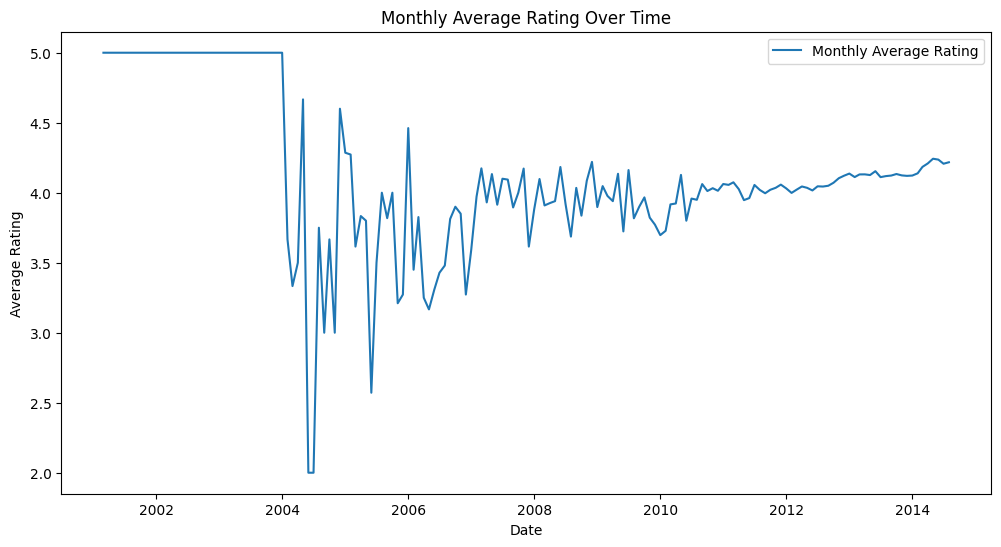

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly['overall'], label='Monthly Average Rating')
plt.title('Monthly Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

In [ ]:
df['review_length'] = df['reviewText'].str.len()

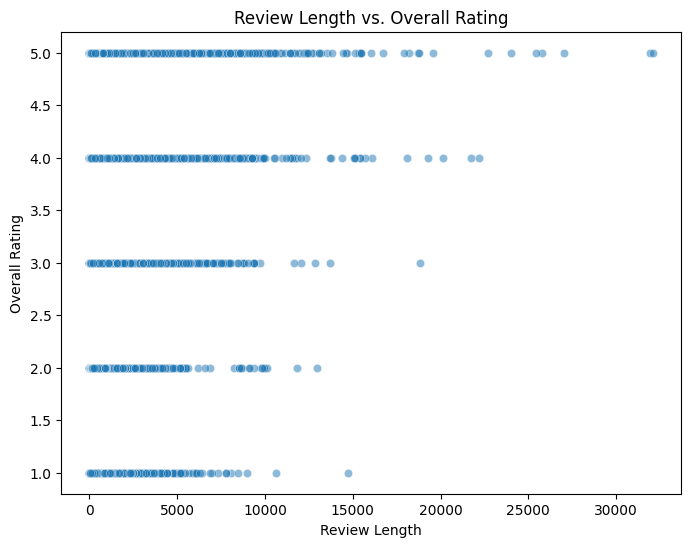

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='review_length', y='overall', alpha=0.5)
plt.title("Review Length vs. Overall Rating")
plt.xlabel("Review Length")
plt.ylabel("Overall Rating")
plt.show()

## Sentiment Analysis

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df['sentiment_score'] = df['reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [ ]:
monthly_sentiment = df.resample('M')['sentiment_score'].mean()

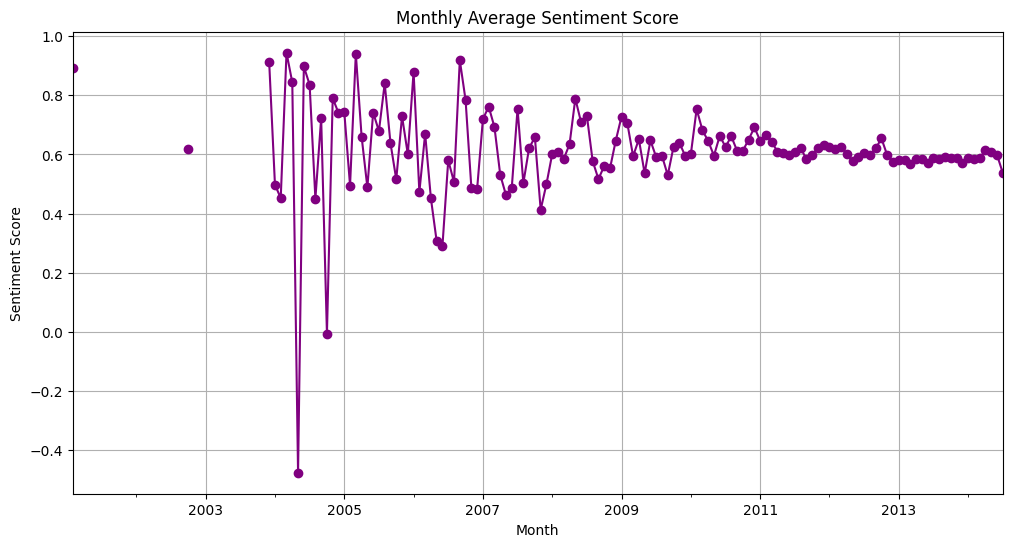

In [ ]:
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', color='purple', marker='o')
plt.title("Monthly Average Sentiment Score")
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.show()

## Splitting the dataset

In [ ]:
split_point = int(len(df_monthly) * 0.8)
train = df_monthly.iloc[:split_point]
test = df_monthly.iloc[split_point:]

## ARIMA Model

In [ ]:
stepwise_model = auto_arima(train['overall'], start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=None, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=239.413, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=184.278, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=240.069, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=196.773, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=181.169, Time=1.67 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.43 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=234.171, Time=0.26 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=174.669, Time=0.60 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=178.829, Time=0.24 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=170.995, Time=

In [ ]:
stepwise_model.fit(train['overall'])

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
n_periods = len(test)
forecast_arima = stepwise_model.predict(n_periods=n_periods)
forecast_arima = pd.DataFrame(forecast_arima, index=test.index, columns=['Prediction_ARIMA'])

## Evaluating ARIMA Model

In [ ]:
mae_arima = mean_absolute_error(test['overall'], forecast_arima['Prediction_ARIMA'])
rmse_arima = np.sqrt(mean_squared_error(test['overall'], forecast_arima['Prediction_ARIMA']))

In [ ]:
print(f'ARIMA Model MAE: {mae_arima}')
print(f'ARIMA Model RMSE: {rmse_arima}')

ARIMA Model MAE: 0.11911278564402424
ARIMA Model RMSE: 0.14093654720536508


## Plotting ARIMA Predictions

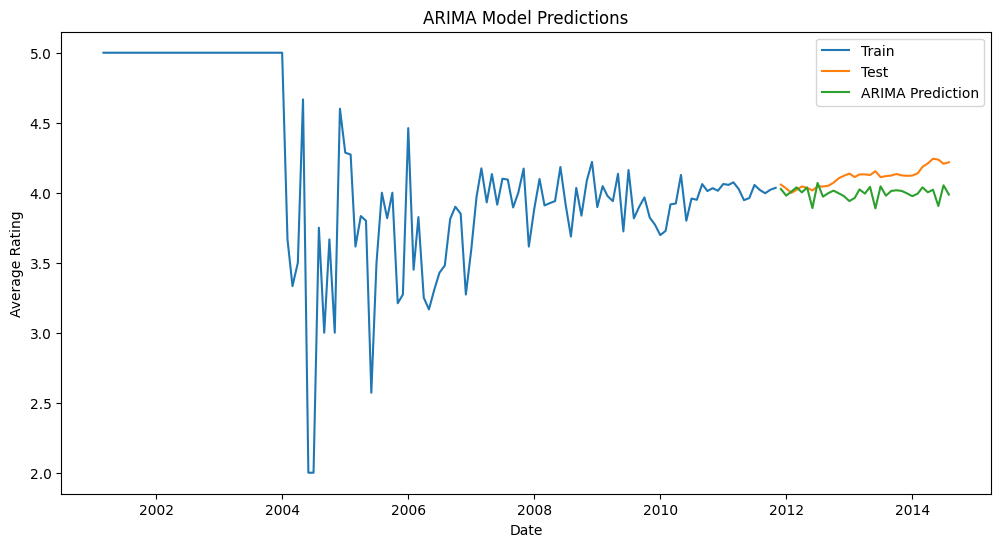

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['overall'], label='Train')
plt.plot(test['overall'], label='Test')
plt.plot(forecast_arima['Prediction_ARIMA'], label='ARIMA Prediction')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

## Prophet Model

In [ ]:
df_prophet = df_monthly.reset_index().rename(columns={'date':'ds', 'overall':'y'})

In [ ]:
train_prophet = df_prophet.iloc[:split_point]
test_prophet = df_prophet.iloc[split_point:]

In [ ]:
model_prophet = Prophet()
model_prophet.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjz2cqy25/s_d11f9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjz2cqy25/bx_0apxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64161', 'data', 'file=/tmp/tmpjz2cqy25/s_d11f9g.json', 'init=/tmp/tmpjz2cqy25/bx_0apxa.json', 'output', 'file=/tmp/tmpjz2cqy25/prophet_model278mb5kh/prophet_model-20241211205133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:51:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model_prophet.make_future_dataframe(periods=n_periods, freq='M')

In [ ]:
forecast_prophet = model_prophet.predict(future)

In [ ]:
forecast_prophet = forecast_prophet.set_index('ds')
forecast_prophet = forecast_prophet[['yhat']]
forecast_prophet = forecast_prophet.loc[test.index]

## Evaluating Prophet Model

In [ ]:
mae_prophet = mean_absolute_error(test['overall'], forecast_prophet['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(test['overall'], forecast_prophet['yhat']))

In [ ]:
print(f'Prophet Model MAE: {mae_prophet}')
print(f'Prophet Model RMSE: {rmse_prophet}')

Prophet Model MAE: 0.13875491697312098
Prophet Model RMSE: 0.17126497672464955


## Plotting Prophet Predictions

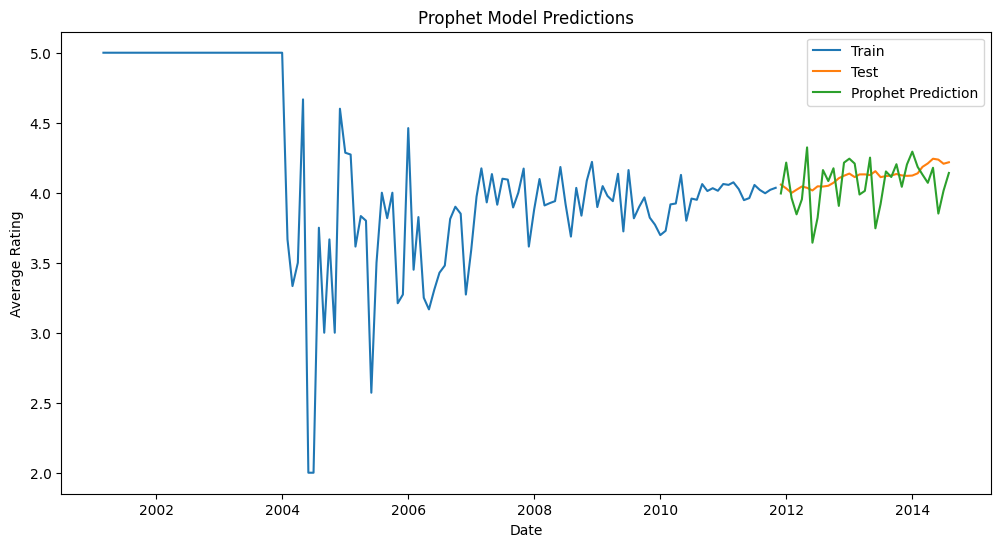

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['overall'], label='Train')
plt.plot(test['overall'], label='Test')
plt.plot(forecast_prophet['yhat'], label='Prophet Prediction')
plt.title('Prophet Model Predictions')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

## LSTM Model

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_monthly)

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
train_size = split_point
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

In [ ]:
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))

In [ ]:
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
126/126 - 4s - 34ms/step - loss: 0.0569
Epoch 2/50
126/126 - 3s - 23ms/step - loss: 0.0225
Epoch 3/50
126/126 - 1s - 5ms/step - loss: 0.0210
Epoch 4/50
126/126 - 0s - 4ms/step - loss: 0.0211
Epoch 5/50
126/126 - 0s - 4ms/step - loss: 0.0217
Epoch 6/50
126/126 - 0s - 4ms/step - loss: 0.0214
Epoch 7/50
126/126 - 0s - 4ms/step - loss: 0.0214
Epoch 8/50
126/126 - 1s - 5ms/step - loss: 0.0206
Epoch 9/50
126/126 - 0s - 4ms/step - loss: 0.0220
Epoch 10/50
126/126 - 0s - 4ms/step - loss: 0.0204
Epoch 11/50
126/126 - 0s - 4ms/step - loss: 0.0202
Epoch 12/50
126/126 - 1s - 5ms/step - loss: 0.0194
Epoch 13/50
126/126 - 0s - 4ms/step - loss: 0.0215
Epoch 14/50
126/126 - 1s - 5ms/step - loss: 0.0194
Epoch 15/50
126/126 - 0s - 4ms/step - loss: 0.0221
Epoch 16/50
126/126 - 1s - 5ms/step - loss: 0.0197
Epoch 17/50
126/126 - 1s - 6ms/step - loss: 0.0209
Epoch 18/50
126/126 - 1s - 5ms/step - loss: 0.0204
Epoch 19/50
126/126 - 1s - 9ms/step - loss: 0.0207
Epoch 20/50
126/126 - 0s - 4ms/step - 

In [ ]:
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])

In [ ]:
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

## Evaluating LSTM Model

In [ ]:
mae_lstm = mean_absolute_error(y_test_inv[0], test_predict[:,0])
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))

In [ ]:
print(f'LSTM Model MAE: {mae_lstm}')
print(f'LSTM Model RMSE: {rmse_lstm}')

LSTM Model MAE: 0.172572770270636
LSTM Model RMSE: 0.17416083426634565


In [ ]:
test_dates = test.index[-len(test_predict):]

In [ ]:
print("Length of test_predict:", len(test_predict))
print("Length of test_dates:", len(test_dates))

Length of test_predict: 33
Length of test_dates: 33


## Plotting LSTM Predictions

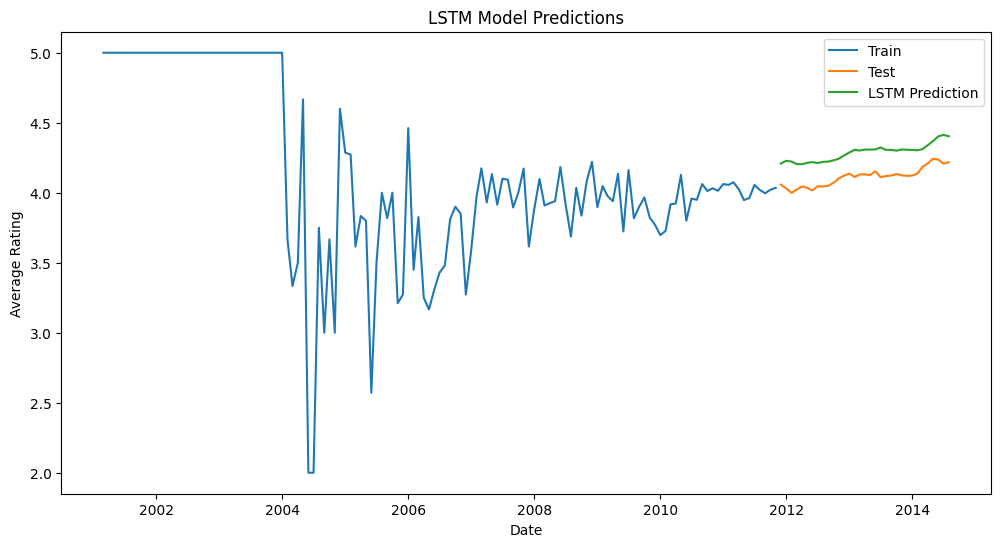

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['overall'], label='Train')
plt.plot(test['overall'], label='Test')
plt.plot(test_dates, test_predict, label='LSTM Prediction')
plt.title('LSTM Model Predictions')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

## Comparing Model Performance

In [ ]:
performance = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'LSTM'],
    'MAE': [mae_arima, mae_prophet, mae_lstm],
    'RMSE': [rmse_arima, rmse_prophet, rmse_lstm]
})

print("\nModel Performance Comparison:")
print(performance)


Model Performance Comparison:
     Model       MAE      RMSE
0    ARIMA  0.119113  0.140937
1  Prophet  0.138755  0.171265
2     LSTM  0.172573  0.174161


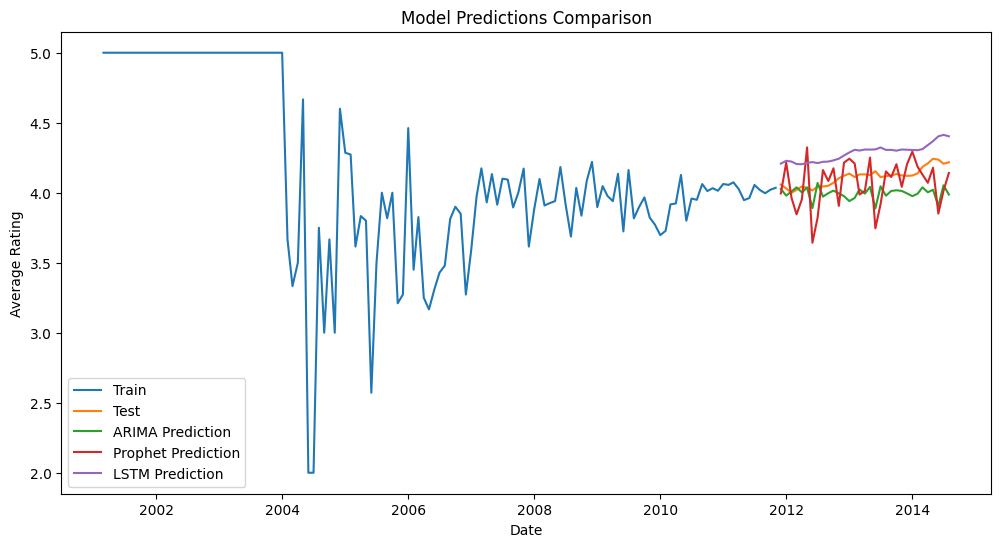

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['overall'], label='Train')
plt.plot(test['overall'], label='Test')
plt.plot(forecast_arima['Prediction_ARIMA'], label='ARIMA Prediction')
plt.plot(forecast_prophet['yhat'], label='Prophet Prediction')
plt.plot(test_dates, test_predict, label='LSTM Prediction')
plt.title('Model Predictions Comparison')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend()
plt.show()

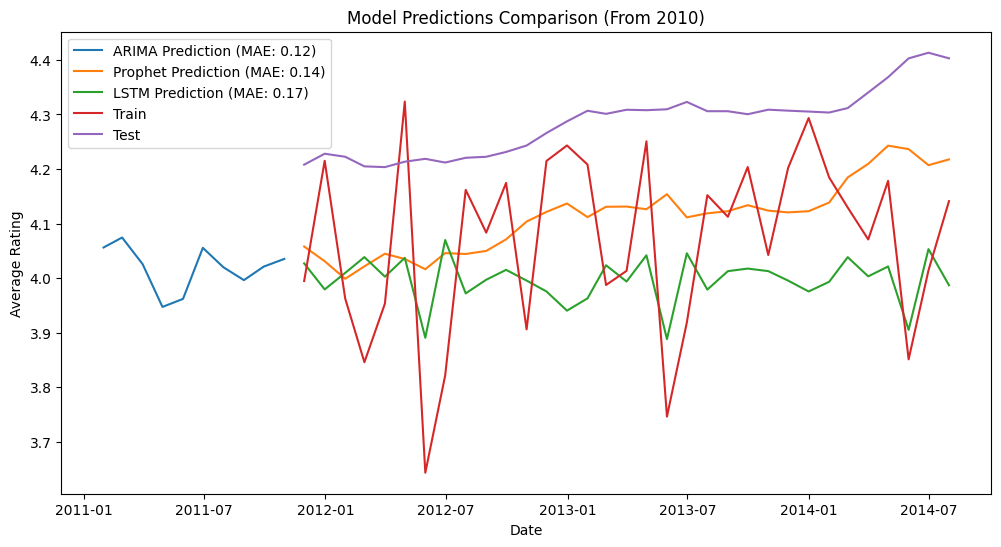

In [ ]:
start_date = pd.to_datetime('2011-01-01')

train_filtered = train[train.index >= start_date]
test_filtered = test[test.index >= start_date]
forecast_arima_filtered = forecast_arima[forecast_arima.index >= start_date]
forecast_prophet_filtered = forecast_prophet[forecast_prophet.index >= start_date]
test_dates_filtered = test_dates[test_dates >= start_date]

plt.figure(figsize=(12, 6))
plt.plot(train_filtered['overall'], label='Train')
plt.plot(test_filtered['overall'], label='Test')
plt.plot(forecast_arima_filtered['Prediction_ARIMA'], label='ARIMA Prediction')
plt.plot(forecast_prophet_filtered['yhat'], label='Prophet Prediction')
plt.plot(test_dates_filtered, test_predict, label='LSTM Prediction')
plt.title('Model Predictions Comparison (From 2010)')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.legend([
       'ARIMA Prediction (MAE: {:.2f})'.format(mae_arima),
       'Prophet Prediction (MAE: {:.2f})'.format(mae_prophet),
       'LSTM Prediction (MAE: {:.2f})'.format(mae_lstm),
       'Train',
       'Test'
   ])
plt.show()

In [ ]:
earliest_date = df.index.min()
latest_date = df.index.max()

print(f"Earliest date: {earliest_date}")
print(f"Latest date: {latest_date}")

Earliest date: 2001-02-22 00:00:00
Latest date: 2014-07-23 00:00:00


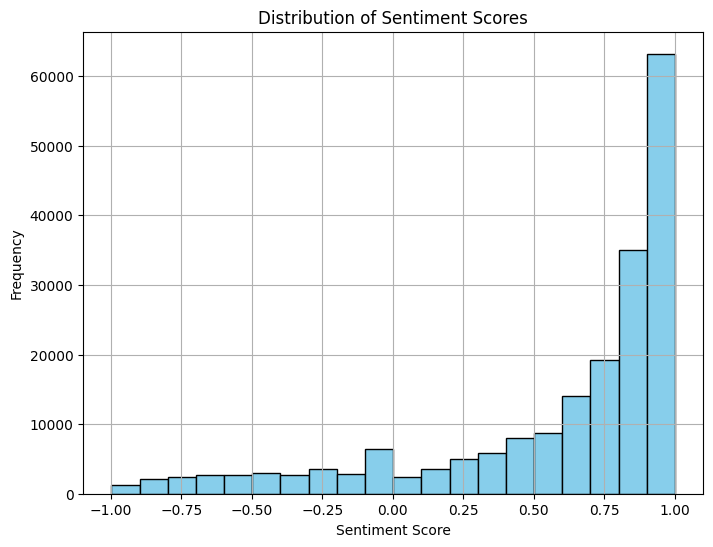

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
p = stepwise_model.order[0]  # p value
d = stepwise_model.order[1]  # d value
q = stepwise_model.order[2]  # q value

print(f"Selected ARIMA parameters: p = {p}, d = {d}, q = {q}")

Selected ARIMA parameters: p = 3, d = 0, q = 0
